## Kalman Filter for X, Y, Z

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import torch

def load_poses(path, sc_factor=1.0):
    poses = []
    with open(path, "r") as f:
        lines = f.readlines()
    for line in lines:
        c2w = np.array(list(map(float, line.split()))).reshape(4, 4)
        c2w[:3, 1] *= -1
        c2w[:3, 2] *= -1
        c2w[:3, 3] *= sc_factor
        c2w = torch.from_numpy(c2w).float()
        poses.append(c2w)
    return poses

def extract_positions(poses):
    positions = []
    for pose in poses:
        position = pose[:3, 3].numpy()
        positions.append(position)  # Now including all x, y, z
    return np.array(positions)

class KalmanFilter:
    def __init__(self, initial_state, initial_P, F, H, Q, R):
        self.state = initial_state
        self.P = initial_P
        self.F = F
        self.H = H
        self.Q = Q
        self.R = R
    
    def predict(self):
        self.state = np.dot(self.F, self.state)
        self.P = np.dot(np.dot(self.F, self.P), self.F.T) + self.Q
    
    def update(self, measurement):
        y = measurement - np.dot(self.H, self.state)
        S = np.dot(np.dot(self.H, self.P), self.H.T) + self.R
        K = np.dot(np.dot(self.P, self.H.T), np.linalg.inv(S))
        self.state = self.state + np.dot(K, y)
        self.P = self.P - np.dot(np.dot(K, self.H), self.P)

# Load and prepare data
poses = load_poses('./data/Replica/room1/traj.txt', sc_factor=1.0)
positions = extract_positions(poses)

# Add some noise to the measurements
noise_std_dev = 0.001
noisy_positions = positions + np.random.normal(0, noise_std_dev, positions.shape)

# Initialize Kalman Filter
dt = 1.0  # time step
F = np.array([[1, 0, 0, dt, 0, 0],
              [0, 1, 0, 0, dt, 0],
              [0, 0, 1, 0, 0, dt],
              [0, 0, 0, 1, 0, 0],
              [0, 0, 0, 0, 1, 0],
              [0, 0, 0, 0, 0, 1]])
H = np.array([[1, 0, 0, 0, 0, 0],
              [0, 1, 0, 0, 0, 0],
              [0, 0, 1, 0, 0, 0]])
Q = np.eye(6) * 0.01
R = np.eye(3) * 0.1
initial_state = np.array([positions[0][0], positions[0][1], positions[0][2], 0, 0, 0])
initial_P = np.eye(6)

kf = KalmanFilter(initial_state, initial_P, F, H, Q, R)

# Apply Kalman Filter
filtered_positions = []
for pos in noisy_positions:
    kf.predict()
    kf.update(pos)
    filtered_positions.append(kf.state[:3])

filtered_positions = np.array(filtered_positions)

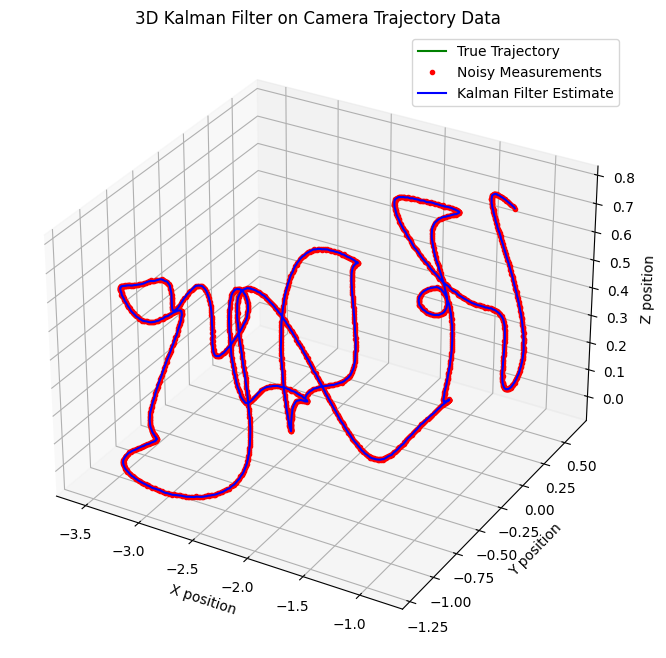

Number of poses processed: 2000
Noise standard deviation: 0.001
Process noise covariance (Q) diagonal: [0.01 0.01 0.01 0.01 0.01 0.01]
Measurement noise covariance (R) diagonal: [0.1 0.1 0.1]


In [5]:
# Plot results
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot(positions[:, 0], positions[:, 1], positions[:, 2], 'g-', label='True Trajectory')
ax.plot(noisy_positions[:, 0], noisy_positions[:, 1], noisy_positions[:, 2], 'r.', label='Noisy Measurements')
ax.plot(filtered_positions[:, 0], filtered_positions[:, 1], filtered_positions[:, 2], 'b-', label='Kalman Filter Estimate')
ax.legend()
ax.set_title('3D Kalman Filter on Camera Trajectory Data')
ax.set_xlabel('X position')
ax.set_ylabel('Y position')
ax.set_zlabel('Z position')
plt.show()

# Print some statistics
print(f"Number of poses processed: {len(positions)}")
print(f"Noise standard deviation: {noise_std_dev}")
print(f"Process noise covariance (Q) diagonal: {np.diagonal(Q)}")
print(f"Measurement noise covariance (R) diagonal: {np.diagonal(R)}")

##
## Making sure the 3d plot is valid by ploting 2 - 2d plots
##

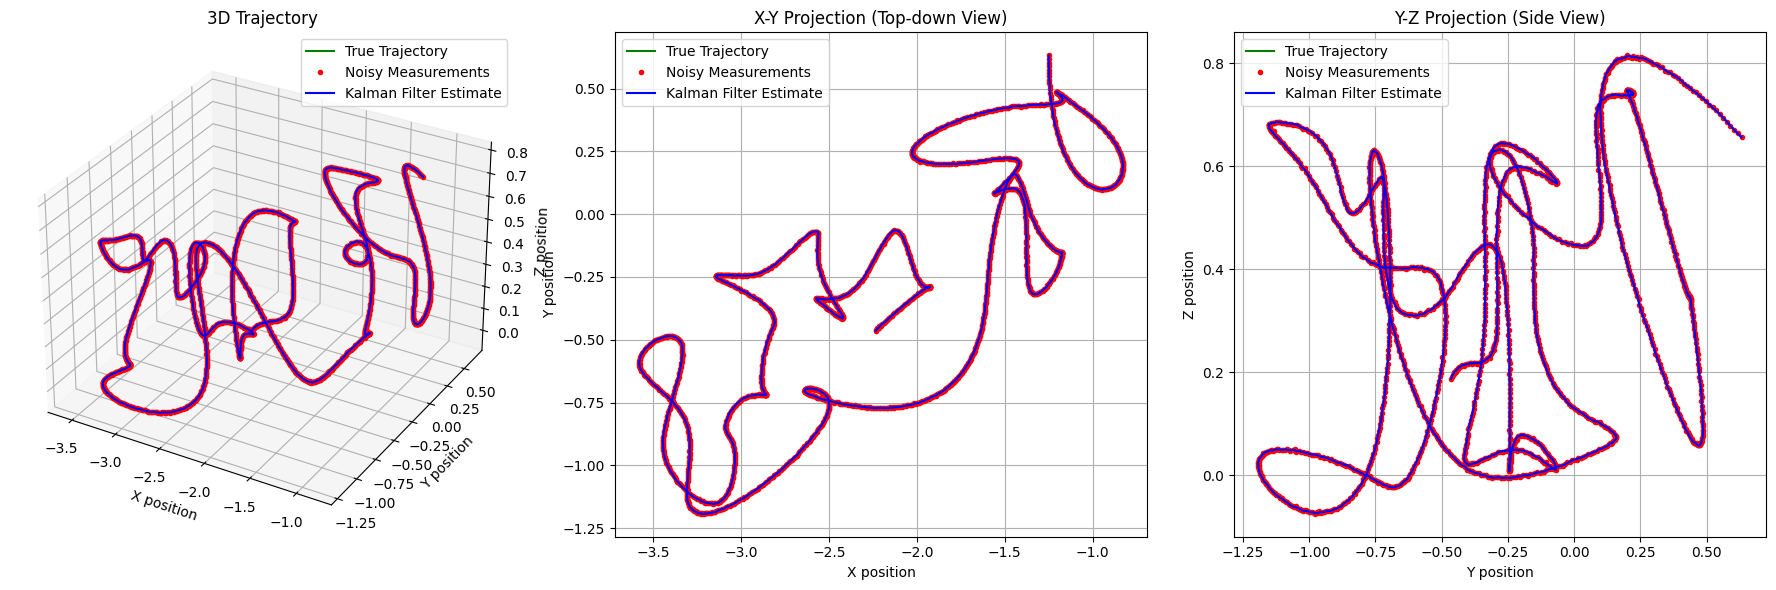

In [72]:
# Plot results
fig = plt.figure(figsize=(18, 6))

# 3D plot
ax1 = fig.add_subplot(131, projection='3d')
ax1.plot(positions[:, 0], positions[:, 1], positions[:, 2], 'g-', label='True Trajectory')
ax1.plot(noisy_positions[:, 0], noisy_positions[:, 1], noisy_positions[:, 2], 'r.', label='Noisy Measurements')
ax1.plot(filtered_positions[:, 0], filtered_positions[:, 1], filtered_positions[:, 2], 'b-', label='Kalman Filter Estimate')
ax1.legend()
ax1.set_title('3D Trajectory')
ax1.set_xlabel('X position')
ax1.set_ylabel('Y position')
ax1.set_zlabel('Z position')

# X-Y projection (top-down view)
ax2 = fig.add_subplot(132)
ax2.plot(positions[:, 0], positions[:, 1], 'g-', label='True Trajectory')
ax2.plot(noisy_positions[:, 0], noisy_positions[:, 1], 'r.', label='Noisy Measurements')
ax2.plot(filtered_positions[:, 0], filtered_positions[:, 1], 'b-', label='Kalman Filter Estimate')
ax2.legend()
ax2.set_title('X-Y Projection (Top-down View)')
ax2.set_xlabel('X position')
ax2.set_ylabel('Y position')
ax2.grid(True)

# Y-Z projection (side view)
ax3 = fig.add_subplot(133)
ax3.plot(positions[:, 1], positions[:, 2], 'g-', label='True Trajectory')
ax3.plot(noisy_positions[:, 1], noisy_positions[:, 2], 'r.', label='Noisy Measurements')
ax3.plot(filtered_positions[:, 1], filtered_positions[:, 2], 'b-', label='Kalman Filter Estimate')
ax3.legend()
ax3.set_title('Y-Z Projection (Side View)')
ax3.set_xlabel('Y position')
ax3.set_ylabel('Z position')
ax3.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
## 

## Full matrix

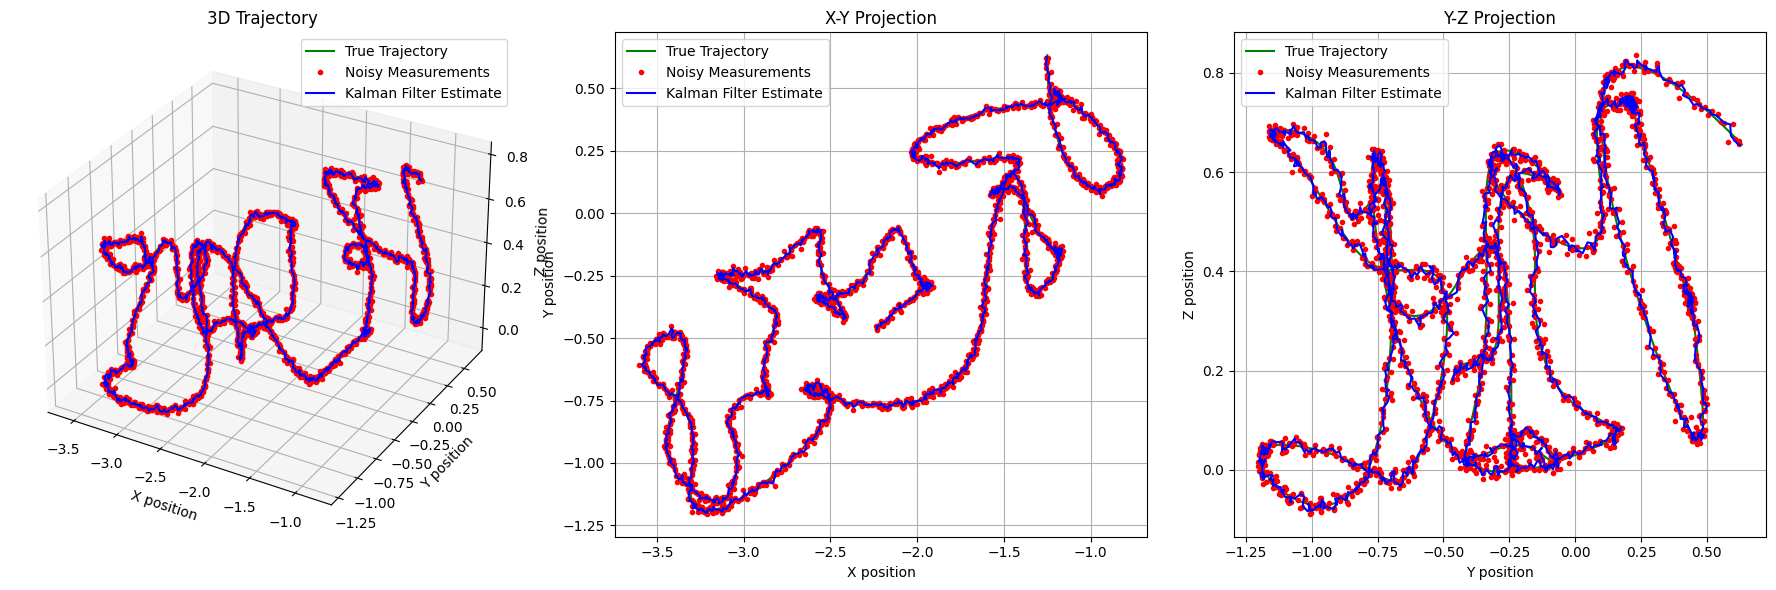

Number of poses processed: 2000
Noise standard deviation: 0.01
Process noise covariance (Q) diagonal: tensor([0.0100, 0.0100, 0.0100, 0.0100, 0.0100])
Measurement noise covariance (R) diagonal: tensor([0.1000, 0.1000, 0.1000])


In [6]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def load_poses(path, sc_factor=1.0):
    poses = []
    with open(path, "r") as f:
        lines = f.readlines()
    for line in lines:
        c2w = torch.tensor(list(map(float, line.split()))).reshape(4, 4)
        c2w[:3, 1] *= -1
        c2w[:3, 2] *= -1
        c2w[:3, 3] *= sc_factor
        poses.append(c2w)
    return poses

def matrix_to_vector(pose_matrix, use_full_pose=False):
    if use_full_pose:
        # Extract rotation matrix (3x3) and translation vector (3x1)
        rotation = pose_matrix[:3, :3]
        translation = pose_matrix[:3, 3]
        # Flatten rotation matrix and concatenate with translation
        return torch.cat([rotation.flatten(), translation])
    else:
        # Return only the translation vector
        return pose_matrix[:3, 3]

class KalmanFilter:
    def __init__(self, initial_state, initial_P, F, H, Q, R):
        self.state = initial_state
        self.P = initial_P
        self.F = F
        self.H = H
        self.Q = Q
        self.R = R
    
    def predict(self):
        self.state = torch.matmul(self.F, self.state)
        self.P = torch.matmul(torch.matmul(self.F, self.P), self.F.t()) + self.Q
    
    def update(self, measurement):
        y = measurement - torch.matmul(self.H, self.state)
        S = torch.matmul(torch.matmul(self.H, self.P), self.H.t()) + self.R
        K = torch.matmul(torch.matmul(self.P, self.H.t()), torch.inverse(S))
        self.state = self.state + torch.matmul(K, y)
        self.P = self.P - torch.matmul(torch.matmul(K, self.H), self.P)

def setup_kalman_filter(initial_state, use_full_pose=False):
    state_dim = 12 if use_full_pose else 3
    measurement_dim = 12 if use_full_pose else 3

    # State transition matrix (assume constant velocity model)
    F = torch.eye(state_dim * 2)
    if use_full_pose:
        # Add velocity components for each pose element
        for i in range(12):
            F[i, i+12] = 1  # dt is assumed to be 1
    else:
        F[:3, 3:] = torch.eye(3)  # dt is assumed to be 1

    # Measurement matrix
    H = torch.eye(measurement_dim, state_dim * 2)

    # Initial state covariance
    P = torch.eye(state_dim * 2) * 0.1

    # Process noise covariance
    Q = torch.eye(state_dim * 2) * 0.01

    # Measurement noise covariance
    R = torch.eye(measurement_dim) * 0.1

    return KalmanFilter(initial_state, P, F, H, Q, R)

# Load and prepare data
poses = load_poses('./data/Replica/room1/traj.txt', sc_factor=1.0)

# Choose whether to use full pose or just position
use_full_pose = False  # Set to True to use full pose

# Convert poses to state vectors
state_vectors = torch.stack([matrix_to_vector(pose, use_full_pose) for pose in poses])

# Add some noise to the measurements
noise_std_dev = 0.01
noisy_state_vectors = state_vectors + torch.randn_like(state_vectors) * noise_std_dev

# Initialize Kalman Filter
initial_state = torch.zeros(24 if use_full_pose else 6)
initial_state[:state_vectors.shape[1]] = state_vectors[0]
kf = setup_kalman_filter(initial_state, use_full_pose)

# Apply Kalman Filter
filtered_states = []
for state in noisy_state_vectors:
    kf.predict()
    kf.update(state)
    filtered_states.append(kf.state[:state_vectors.shape[1]])

filtered_states = torch.stack(filtered_states)

# Extract positions for plotting
if use_full_pose:
    true_positions = state_vectors[:, [9, 10, 11]]
    noisy_positions = noisy_state_vectors[:, [9, 10, 11]]
    filtered_positions = filtered_states[:, [9, 10, 11]]
else:
    true_positions = state_vectors
    noisy_positions = noisy_state_vectors
    filtered_positions = filtered_states

# Convert to numpy for plotting
true_positions = true_positions.numpy()
noisy_positions = noisy_positions.numpy()
filtered_positions = filtered_positions.numpy()

# Plot results
fig = plt.figure(figsize=(18, 6))

# 3D plot
ax1 = fig.add_subplot(131, projection='3d')
ax1.plot(true_positions[:, 0], true_positions[:, 1], true_positions[:, 2], 'g-', label='True Trajectory')
ax1.plot(noisy_positions[:, 0], noisy_positions[:, 1], noisy_positions[:, 2], 'r.', label='Noisy Measurements')
ax1.plot(filtered_positions[:, 0], filtered_positions[:, 1], filtered_positions[:, 2], 'b-', label='Kalman Filter Estimate')
ax1.legend()
ax1.set_title('3D Trajectory')
ax1.set_xlabel('X position')
ax1.set_ylabel('Y position')
ax1.set_zlabel('Z position')

# X-Y projection
ax2 = fig.add_subplot(132)
ax2.plot(true_positions[:, 0], true_positions[:, 1], 'g-', label='True Trajectory')
ax2.plot(noisy_positions[:, 0], noisy_positions[:, 1], 'r.', label='Noisy Measurements')
ax2.plot(filtered_positions[:, 0], filtered_positions[:, 1], 'b-', label='Kalman Filter Estimate')
ax2.legend()
ax2.set_title('X-Y Projection')
ax2.set_xlabel('X position')
ax2.set_ylabel('Y position')
ax2.grid(True)

# Y-Z projection
ax3 = fig.add_subplot(133)
ax3.plot(true_positions[:, 1], true_positions[:, 2], 'g-', label='True Trajectory')
ax3.plot(noisy_positions[:, 1], noisy_positions[:, 2], 'r.', label='Noisy Measurements')
ax3.plot(filtered_positions[:, 1], filtered_positions[:, 2], 'b-', label='Kalman Filter Estimate')
ax3.legend()
ax3.set_title('Y-Z Projection')
ax3.set_xlabel('Y position')
ax3.set_ylabel('Z position')
ax3.grid(True)

plt.tight_layout()
plt.show()

# Print some statistics
print(f"Number of poses processed: {len(poses)}")
print(f"Noise standard deviation: {noise_std_dev}")
print(f"Process noise covariance (Q) diagonal: {kf.Q.diag()[:5]}")
print(f"Measurement noise covariance (R) diagonal: {kf.R.diag()[:5]}")

## Camera motion speed

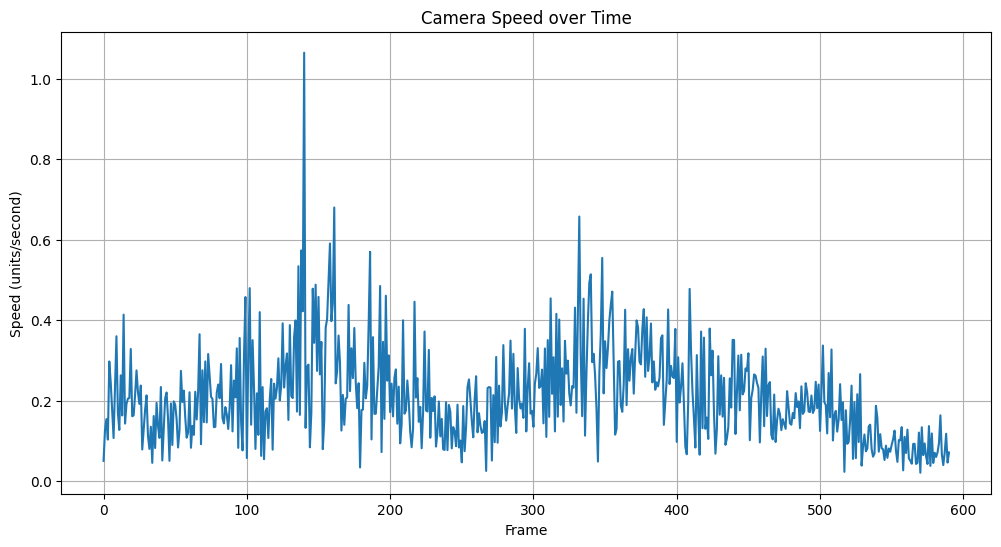

Average speed: 0.2103 units/second
Max speed: 1.0650 units/second
Min speed: 0.0207 units/second


In [24]:
import numpy as np
import matplotlib.pyplot as plt

def load_poses_from_file(file_path):
    poses = []
    with open(file_path, 'r') as f:
        for line in f:
            values = list(map(float, line.strip().split()))
            pose = np.array(values).reshape(4, 4)
            poses.append(pose)
    return np.array(poses)

def euclidean_distance(pos1, pos2):
    return np.linalg.norm(pos1 - pos2)

def compute_camera_speed(prev_pose, curr_pose, time_elapsed):
    prev_pos = prev_pose[:3, 3]
    curr_pos = curr_pose[:3, 3]
    distance = euclidean_distance(prev_pos, curr_pos)
    speed = distance / time_elapsed
    return speed

# Load poses from file
file_path = './output/TUM/fr_desk/demo/estimated_trajectory.txt'
poses = load_poses_from_file(file_path)

# Set a fixed time elapsed between frames (you can adjust this value)
time_elapsed = 0.1  # seconds

# Calculate speeds
speeds = []
for i in range(1, len(poses)):
    prev_pose = poses[i-1]
    curr_pose = poses[i]
    speed = compute_camera_speed(prev_pose, curr_pose, time_elapsed)
    speeds.append(speed)

# Plot the speeds
plt.figure(figsize=(12, 6))
plt.plot(speeds)
plt.title('Camera Speed over Time')
plt.xlabel('Frame')
plt.ylabel('Speed (units/second)')
plt.grid(True)
plt.show()

# Print some statistics
print(f"Average speed: {np.mean(speeds):.4f} units/second")
print(f"Max speed: {np.max(speeds):.4f} units/second")
print(f"Min speed: {np.min(speeds):.4f} units/second")

Correlation between speed and translation error: 0.2513
Correlation between speed and rotation error: 0.0597


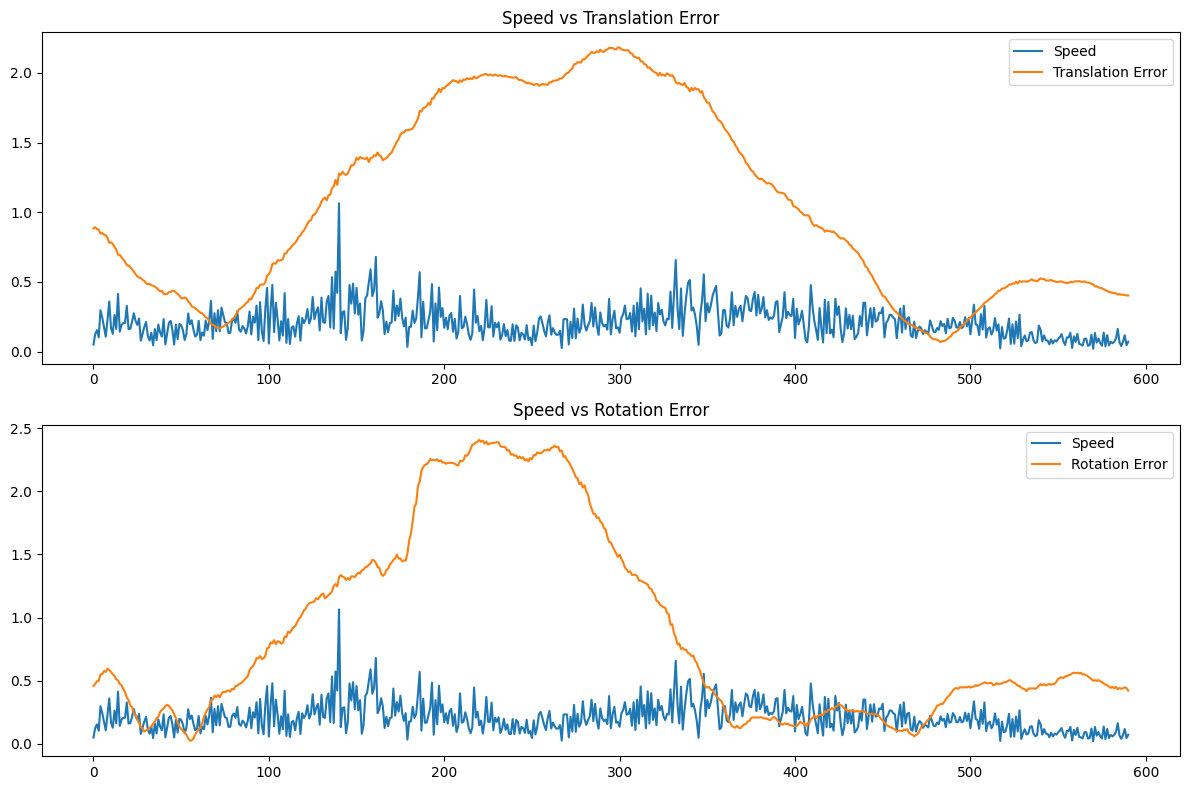

In [25]:
import numpy as np
from scipy.spatial.transform import Rotation

import numpy as np

def load_tum_ground_truth_poses(file_path):
    poses = []
    with open(file_path, 'r') as f:
        lines = f.readlines()
        for line in lines:
            if line.startswith('#'):
                continue
            data = line.split()
            if len(data) != 8:
                continue
            timestamp = float(data[0])
            tx, ty, tz = map(float, data[1:4])
            qx, qy, qz, qw = map(float, data[4:8])
            
            # Convert quaternion to rotation matrix
            R = quaternion_to_rotation_matrix([qw, qx, qy, qz])
            
            # Create 4x4 transformation matrix
            T = np.eye(4)
            T[:3, :3] = R
            T[:3, 3] = [tx, ty, tz]
            
            poses.append((timestamp, T))
    
    # Sort poses by timestamp
    poses.sort(key=lambda x: x[0])
    
    # Extract only the transformation matrices
    pose_matrices = [pose[1] for pose in poses]
    
    return np.array(pose_matrices)

def quaternion_to_rotation_matrix(q):
    w, x, y, z = q
    R = np.array([
        [1 - 2*y*y - 2*z*z, 2*x*y - 2*z*w, 2*x*z + 2*y*w],
        [2*x*y + 2*z*w, 1 - 2*x*x - 2*z*z, 2*y*z - 2*x*w],
        [2*x*z - 2*y*w, 2*y*z + 2*x*w, 1 - 2*x*x - 2*y*y]
    ])
    return R



def calculate_pose_error(gt_pose, est_pose):
    # Translation error
    trans_error = np.linalg.norm(gt_pose[:3, 3] - est_pose[:3, 3])
    
    # Rotation error
    R_gt = Rotation.from_matrix(gt_pose[:3, :3])
    R_est = Rotation.from_matrix(est_pose[:3, :3])
    R_diff = R_gt.inv() * R_est
    rot_error = R_diff.magnitude()
    
    return trans_error, rot_error

# Load poses
gt_poses = load_tum_ground_truth_poses('./data/TUM/rgbd_dataset_freiburg1_desk/groundtruth.txt')
est_poses = load_poses_from_file('./output/TUM/fr_desk/demo/estimated_trajectory.txt')

# Calculate errors and speeds
trans_errors = []
rot_errors = []
speeds = []
time_elapsed = 0.1  # adjust as needed

for i in range(1, len(est_poses)):
    trans_error, rot_error = calculate_pose_error(gt_poses[i], est_poses[i])
    trans_errors.append(trans_error)
    rot_errors.append(rot_error)
    
    speed = compute_camera_speed(est_poses[i-1], est_poses[i], time_elapsed)
    speeds.append(speed)

# Calculate correlations
correlation_trans = np.corrcoef(speeds, trans_errors)[0, 1]
correlation_rot = np.corrcoef(speeds, rot_errors)[0, 1]

print(f"Correlation between speed and translation error: {correlation_trans:.4f}")
print(f"Correlation between speed and rotation error: {correlation_rot:.4f}")

# Plot
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(speeds, label='Speed')
plt.plot(trans_errors, label='Translation Error')
plt.legend()
plt.title('Speed vs Translation Error')

plt.subplot(2, 1, 2)
plt.plot(speeds, label='Speed')
plt.plot(rot_errors, label='Rotation Error')
plt.legend()
plt.title('Speed vs Rotation Error')

plt.tight_layout()
plt.show()

In [30]:
import numpy as np

def load_tum_ground_truth_poses(file_path):
    poses = []
    timestamps = []
    with open(file_path, 'r') as f:
        lines = f.readlines()
        for line in lines:
            if line.startswith('#'):
                continue
            data = line.split()
            if len(data) != 8:
                continue
            timestamp = float(data[0])
            tx, ty, tz = map(float, data[1:4])
            qx, qy, qz, qw = map(float, data[4:8])
            
            # Convert quaternion to rotation matrix
            R = quaternion_to_rotation_matrix([qw, qx, qy, qz])
            
            # Create 4x4 transformation matrix
            T = np.eye(4)
            T[:3, :3] = R
            T[:3, 3] = [tx, ty, tz]
            
            poses.append(T)
            timestamps.append(timestamp)
    
    return np.array(poses), np.array(timestamps)

def quaternion_to_rotation_matrix(q):
    w, x, y, z = q
    R = np.array([
        [1 - 2*y*y - 2*z*z, 2*x*y - 2*z*w, 2*x*z + 2*y*w],
        [2*x*y + 2*z*w, 1 - 2*x*x - 2*z*z, 2*y*z - 2*x*w],
        [2*x*z - 2*y*w, 2*y*z + 2*x*w, 1 - 2*x*x - 2*y*y]
    ])
    return R

# Usage
gt_poses, gt_timestamps = load_tum_ground_truth_poses('./data/TUM/rgbd_dataset_freiburg3_long_office_household/groundtruth.txt')

In [31]:
def compute_camera_speed(prev_pose, curr_pose, prev_time, curr_time):
    prev_pos = prev_pose[:3, 3]
    curr_pos = curr_pose[:3, 3]
    distance = np.linalg.norm(curr_pos - prev_pos)
    time_elapsed = curr_time - prev_time
    speed = distance / time_elapsed
    return speed

/home/aspegique/anaconda3/envs/coslam/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in arccos


Correlation between speed and translation error: -0.0615
Correlation between speed and rotation error: nan


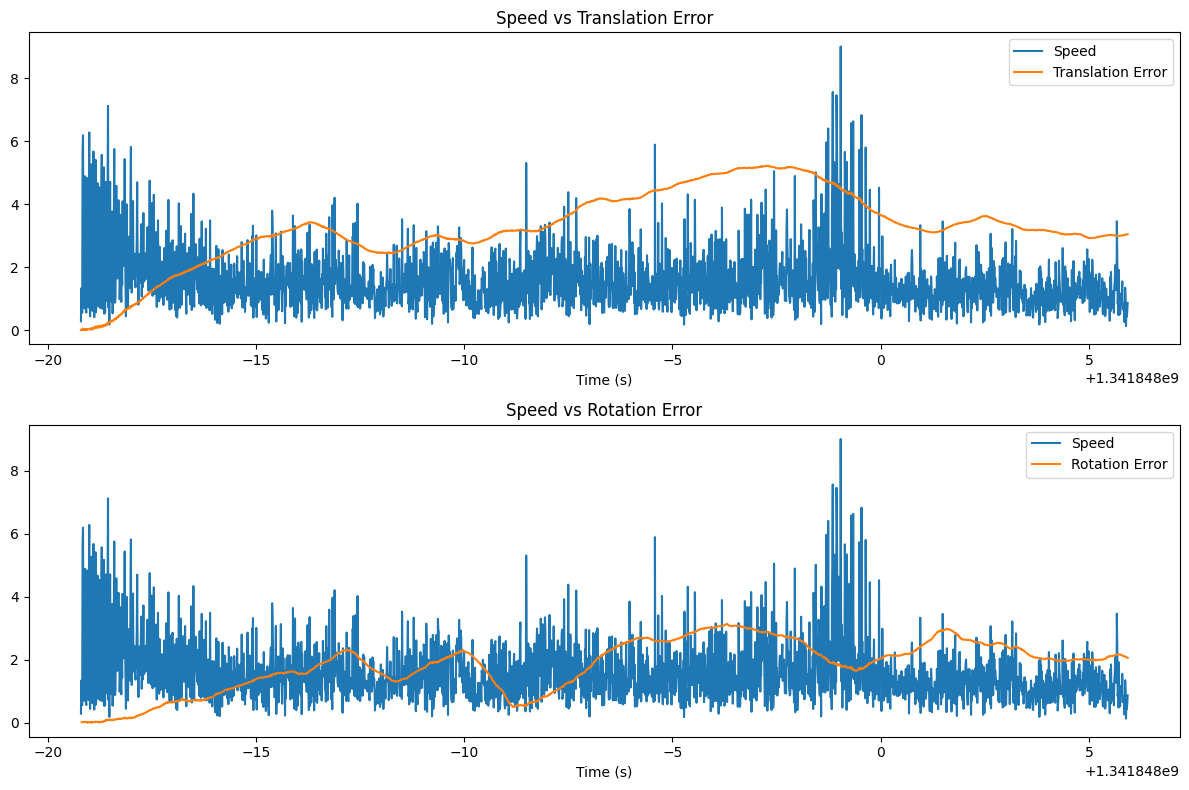

Average speed: 1.5753 units/second
Max speed: 9.0048 units/second
Min speed: 0.1301 units/second


In [32]:
# Load estimated poses
est_poses = load_poses_from_file('./output/TUM/fr_office/demo/estimated_trajectory.txt')

# Make sure we have the same number of poses
min_poses = min(len(gt_poses), len(est_poses))
gt_poses = gt_poses[:min_poses]
est_poses = est_poses[:min_poses]
timestamps = gt_timestamps[:min_poses]

def compute_camera_speed(prev_pose, curr_pose, prev_time, curr_time):
    prev_pos = prev_pose[:3, 3]
    curr_pos = curr_pose[:3, 3]
    distance = np.linalg.norm(curr_pos - prev_pos)
    time_elapsed = curr_time - prev_time
    speed = distance / time_elapsed
    return speed

def calculate_pose_error(gt_pose, est_pose):
    # Translation error
    trans_error = np.linalg.norm(gt_pose[:3, 3] - est_pose[:3, 3])
    
    # Rotation error
    R_gt = gt_pose[:3, :3]
    R_est = est_pose[:3, :3]
    R_diff = np.dot(R_gt.T, R_est)
    rot_error = np.arccos((np.trace(R_diff) - 1) / 2)
    
    return trans_error, rot_error

# Calculate speeds and errors
speeds = []
trans_errors = []
rot_errors = []

for i in range(1, len(est_poses)):
    # Calculate speed
    speed = compute_camera_speed(est_poses[i-1], est_poses[i], timestamps[i-1], timestamps[i])
    speeds.append(speed)
    
    # Calculate pose error
    trans_error, rot_error = calculate_pose_error(gt_poses[i], est_poses[i])
    trans_errors.append(trans_error)
    rot_errors.append(rot_error)

# Calculate correlations
correlation_trans = np.corrcoef(speeds, trans_errors)[0, 1]
correlation_rot = np.corrcoef(speeds, rot_errors)[0, 1]

print(f"Correlation between speed and translation error: {correlation_trans:.4f}")
print(f"Correlation between speed and rotation error: {correlation_rot:.4f}")

# Plot
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(timestamps[1:], speeds, label='Speed')
plt.plot(timestamps[1:], trans_errors, label='Translation Error')
plt.legend()
plt.title('Speed vs Translation Error')
plt.xlabel('Time (s)')

plt.subplot(2, 1, 2)
plt.plot(timestamps[1:], speeds, label='Speed')
plt.plot(timestamps[1:], rot_errors, label='Rotation Error')
plt.legend()
plt.title('Speed vs Rotation Error')
plt.xlabel('Time (s)')

plt.tight_layout()
plt.show()

# Print some statistics
print(f"Average speed: {np.mean(speeds):.4f} units/second")
print(f"Max speed: {np.max(speeds):.4f} units/second")
print(f"Min speed: {np.min(speeds):.4f} units/second")

## Calculate Motion for Replica

In [33]:
import numpy as np
import matplotlib.pyplot as plt

def load_poses_from_file(file_path):
    poses = []
    with open(file_path, 'r') as f:
        for line in f:
            values = list(map(float, line.strip().split()))
            pose = np.array(values).reshape(4, 4)
            poses.append(pose)
    return np.array(poses)

def load_replica_ground_truth_poses(file_path):
    return load_poses_from_file(file_path)

def compute_camera_speed(prev_pose, curr_pose, time_elapsed):
    prev_pos = prev_pose[:3, 3]
    curr_pos = curr_pose[:3, 3]
    distance = np.linalg.norm(curr_pos - prev_pos)
    speed = distance / time_elapsed
    return speed

def calculate_pose_error(gt_pose, est_pose):
    # Translation error
    trans_error = np.linalg.norm(gt_pose[:3, 3] - est_pose[:3, 3])
    
    # Rotation error
    R_gt = gt_pose[:3, :3]
    R_est = est_pose[:3, :3]
    R_diff = np.dot(R_gt.T, R_est)
    rot_error = np.arccos(np.clip((np.trace(R_diff) - 1) / 2, -1, 1))
    
    return trans_error, rot_error

def analyze_trajectory(gt_path, est_path, time_step=0.1):
    # Load poses
    gt_poses = load_replica_ground_truth_poses(gt_path)
    est_poses = load_poses_from_file(est_path)

    # Make sure we have the same number of poses
    min_poses = min(len(gt_poses), len(est_poses))
    gt_poses = gt_poses[:min_poses]
    est_poses = est_poses[:min_poses]

    # Calculate speeds and errors
    speeds = []
    trans_errors = []
    rot_errors = []

    for i in range(1, len(est_poses)):
        speed = compute_camera_speed(est_poses[i-1], est_poses[i], time_step)
        speeds.append(speed)
        
        trans_error, rot_error = calculate_pose_error(gt_poses[i], est_poses[i])
        trans_errors.append(trans_error)
        rot_errors.append(rot_error)

    # Calculate correlations
    correlation_trans = np.corrcoef(speeds, trans_errors)[0, 1]
    correlation_rot = np.corrcoef(speeds, rot_errors)[0, 1]

    # Plot
    time_points = np.arange(len(speeds)) * time_step
    plt.figure(figsize=(12, 8))
    plt.subplot(2, 1, 1)
    plt.plot(time_points, speeds, label='Speed')
    plt.plot(time_points, trans_errors, label='Translation Error')
    plt.legend()
    plt.title('Speed vs Translation Error')
    plt.xlabel('Time (s)')
    plt.ylabel('Units')

    plt.subplot(2, 1, 2)
    plt.plot(time_points, speeds, label='Speed')
    plt.plot(time_points, rot_errors, label='Rotation Error')
    plt.legend()
    plt.title('Speed vs Rotation Error')
    plt.xlabel('Time (s)')
    plt.ylabel('Units')

    plt.tight_layout()
    plt.show()

    # Print statistics
    print(f"Correlation between speed and translation error: {correlation_trans:.4f}")
    print(f"Correlation between speed and rotation error: {correlation_rot:.4f}")
    print(f"Average speed: {np.mean(speeds):.4f} units/second")
    print(f"Max speed: {np.max(speeds):.4f} units/second")
    print(f"Min speed: {np.min(speeds):.4f} units/second")
    print(f"Average translation error: {np.mean(trans_errors):.4f} units")
    print(f"Average rotation error: {np.mean(rot_errors):.4f} radians")

    return speeds, trans_errors, rot_errors

# Usage in Jupyter Notebook
# Just run this cell to define all functions

# Then in a new cell, you can simply call:
# analyze_trajectory('path/to/ground_truth.txt', 'path/to/estimated_trajectory.txt')

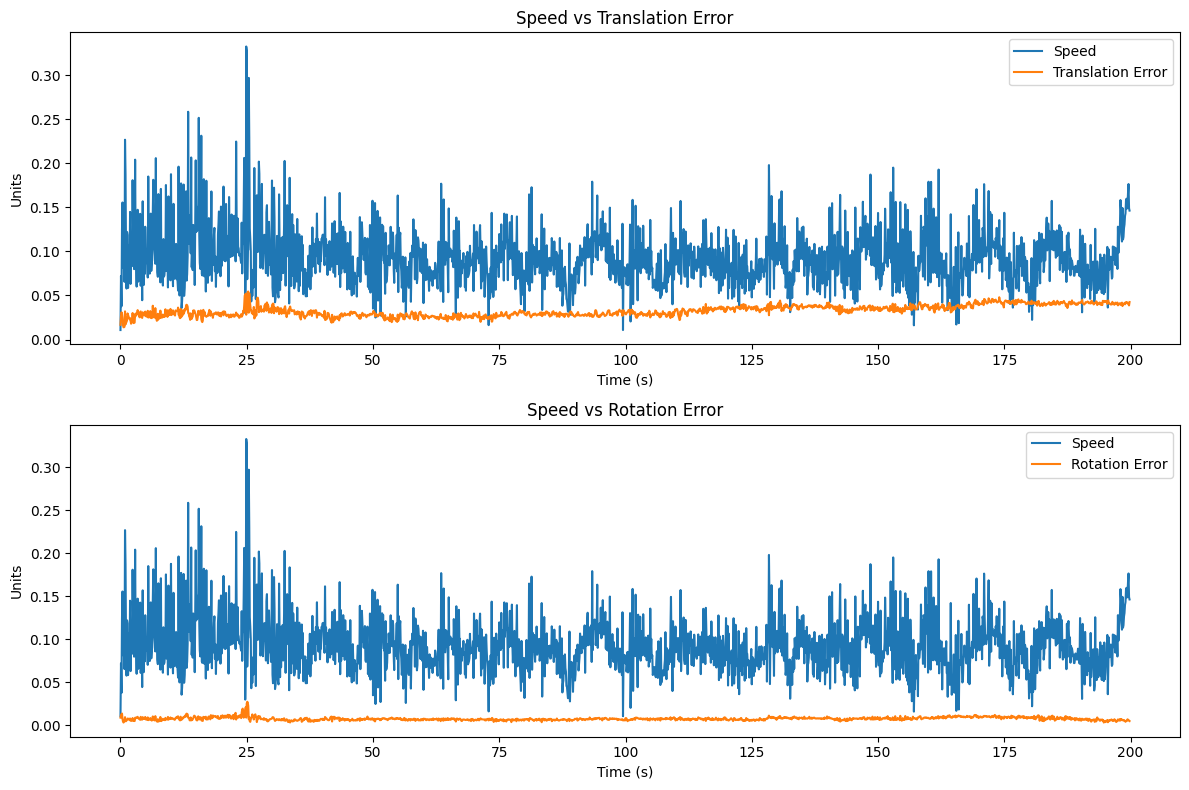

Correlation between speed and translation error: -0.0146
Correlation between speed and rotation error: 0.0779
Average speed: 0.0920 units/second
Max speed: 0.3327 units/second
Min speed: 0.0108 units/second
Average translation error: 0.0325 units
Average rotation error: 0.0078 radians


In [36]:
# Analyze a single scene
scene_name = "room1"

gt_path = f"./data/Replica/{scene_name}/traj.txt"
est_path = f"./output/Replica/{scene_name}/demo/estimated_trajectory.txt"

speeds, trans_errors, rot_errors = analyze_trajectory(gt_path, est_path)